# Analiza eksperymentu A/B na podstawie logów

* Logi z serwisu zawierają dla każdej predykcji
  * id użytkownika
  * użyty model
  * id listingu
  * wartość predykcji
  * parametry wywołania
* Na podstawie id oferty wyszukujemy rzeczywistą ocenę w zbiorze testowym

## Opis eksperymentu
* Na podstawie zbioru testowego wysyłamy zapytania do serwisu predykcyjnego
* Zbieramy logi z serwisu
* Na podstawie błędu kwadratowego predykcji porównujemy jakość modeli

In [1]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_rel

EXPERIMENT_SET = "../data/processed/experiment_set.csv"
LOG_FILE = "../data/service.log"
BASE_MODEL_NAME = "RandomBaseModel"
NEW_MODEL_NAME = "LinearRegressionModel"

## Przetwarzanie logów

In [2]:
regex = re.compile(
    r"Predicted (?P<prediction>[0-9.]+) for user (?P<user_id>[a-f0-9\-]+), using model (?P<model_name>\w+), given params: (?P<params>\{.*\})")


def parse_log_line(log_line: str):
    log_line = log_line.strip()
    parsed = re.search(regex, log_line).groupdict()
    params_dict = json.loads(parsed["params"])
    parsed.pop("params")
    for key, val in params_dict.items():
        parsed[key] = val

    return parsed


with open(LOG_FILE) as f:
    logs = pd.DataFrame([
        parse_log_line(line)
        for line in f
        if "PredictionService" in line
    ])

In [3]:
logs = logs.loc[:, ["prediction", "model_name", "id"]]
logs.loc[:, "id"] = logs["id"].astype(int)
logs["prediction"] = pd.to_numeric(logs["prediction"])

In [4]:
test_set = pd.read_csv(EXPERIMENT_SET)
test_set = test_set[["id", "avg_rating"]]
test_set.rename(columns={"avg_rating": "real_rating"}, inplace=True)

In [5]:
logs = logs.merge(test_set, on="id", how="left")
logs["squared_error"] = ((logs["prediction"] - logs["real_rating"]) ** 2)

In [6]:
logs

,prediction,model_name,id,real_rating,squared_error
0,4.569796,RandomBaseModel,45736361,4.974286,0.163612
1,4.809988,RandomBaseModel,16245894,4.801429,0.000073
2,4.645126,RandomBaseModel,53288372,4.847143,0.040811
3,4.331700,RandomBaseModel,35991083,4.865714,0.285172
4,4.405404,RandomBaseModel,21689254,4.878571,0.223887
...,...,...,...,...,...
1283,5.000000,LinearRegressionModel,1035493789735740124,4.924286,0.005733
1284,5.000000,LinearRegressionModel,598351785185079269,4.324286,0.456590
1285,5.000000,LinearRegressionModel,2201228,4.708571,0.084931
1286,5.000000,LinearRegressionModel,3070635,4.781429,0.047773


In [7]:
logs_a = logs[logs["model_name"] == NEW_MODEL_NAME]
logs_b = logs[logs["model_name"] == BASE_MODEL_NAME]

## Wizualizacja wyników

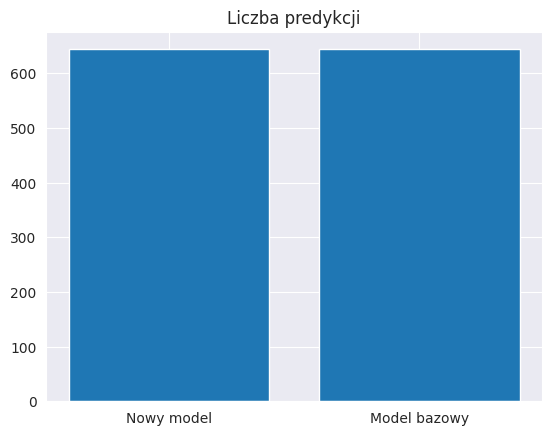

In [8]:
plt.bar(x=["Nowy model", "Model bazowy"], height=[len(logs_a), len(logs_b)])
plt.title("Liczba predykcji")
plt.show()

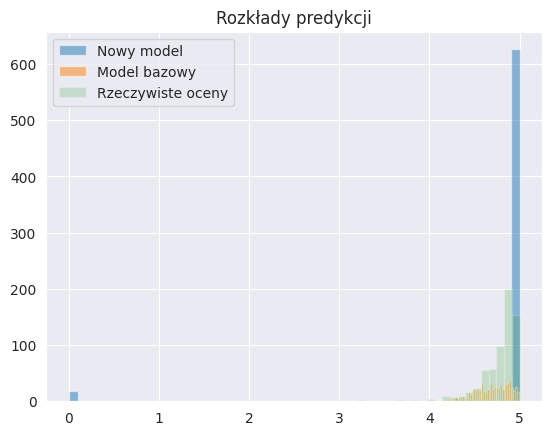

In [13]:
plt.hist(logs_a["prediction"].astype(float), bins=50, alpha=0.5, label="Nowy model")
plt.hist(logs_b["prediction"].astype(float), bins=50, alpha=0.5, label="Model bazowy")
plt.hist(logs_a["real_rating"].astype(float), bins=50, alpha=0.2, label="Rzeczywiste oceny")
plt.legend()
plt.title("Rozkłady predykcji")
plt.show()

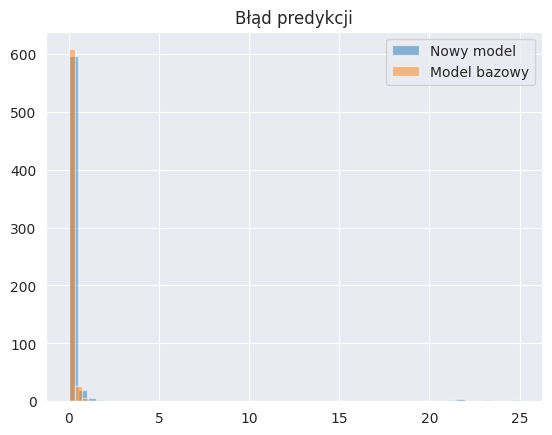

In [10]:
plt.hist(logs_a["squared_error"], bins=50, alpha=0.5, label="Nowy model")
plt.hist(logs_b["squared_error"], bins=50, alpha=0.5, label="Model bazowy")
plt.legend()
plt.title("Błąd predykcji")
plt.show()

## Test statystyczny

### Hipotezy

* $H_0$: Nowy model (A) nie jest lepszy od modelu bazowego (B)
* $H_1$: Nowy model (A) jest lepszy od modelu bazowego (B)
* Porównujemy błędy średniokeadratowego - mniejszy błąd oznacza lepszy model

$$ H_0: err_A \ge err_B $$

$$ H_1: err_A < err_B $$

### Test
* Wykorzystamy test t-Studenta dla dwóch prób
* Przyjmujemy poziom istotności $\alpha = 0.05$
* P-wartość oznacza prawdopodobieństwo obserwacji wyników, w świecie, w którym hipoteza zerowa jest prawdziwa.
* Jeśli p-wartość jest mniejsza od poziomu istotności, to odrzucamy hipotezę zerową.

In [11]:
alpha = 0.05
t_stat, p_value = ttest_rel(logs_a["squared_error"], logs_b["squared_error"])
print(f"Alpha: {alpha}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Reject H0, p<alpha, new model is better")
else:
    print("Fail to reject H0, p>=alpha, new model is not better")

Alpha: 0.05
t-statistic: 4.2954
p-value: 0.0000
Reject H0, p<alpha, new model is better


Ponieważ $p \ll \alpha$, odrzucamy hipotezę zerową i przyjmujemy, że nowy model jest lepszy od modelu bazowego.